# Train model for MNIST 
    - MNIST data
    - resnet network with dilated convolutions

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import h5py

import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 


path = '/home/jorge/data/tesis/handwriting/p06_dilated_convolutions/'

In [2]:
#Read MNIST data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp", one_hot=True)

print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(55000, 10)
(10000, 10)


In [3]:
import tensorflow as tf

# Start an interactive session
sess = tf.InteractiveSession()


In [4]:
def conv11(input_, output_channels=256, name='conv1'):
    input_shape = input_.get_shape()
    input_channels = int(input_shape[-1])
    filter_ = tf.get_variable('w_'+name, [1, 1, input_channels, output_channels], 
                              initializer=tf.truncated_normal_initializer(stddev=0.001))
    conv = tf.nn.convolution(input_, filter_, padding = 'SAME')
    biases = tf.get_variable('biases_'+name, [output_channels], initializer=tf.constant_initializer(0.0))
    conv = tf.nn.bias_add(conv, biases)
    return conv

def conv11_dilated(input_, dilation=1, output_channels=256, name='conv1'):
    input_shape = input_.get_shape()
    input_channels = int(input_shape[-1])
    filter_ = tf.get_variable('w_'+name, [3, 3, input_channels, output_channels], 
                              initializer=tf.truncated_normal_initializer(stddev=0.001))
    conv = tf.nn.convolution(input_, filter_, dilation_rate = [dilation, dilation], padding = 'SAME')
    biases = tf.get_variable('biases_'+name, [output_channels], initializer=tf.constant_initializer(0.0))
    conv = tf.nn.bias_add(conv, biases)
    return conv



def residual_layer(input_, dilation, channels=64, name='residual'):
    '''
    relu
    relu(convolution([1, 1, x.size, n_channels1])
    relu(convolution([1, 3, n_channels1, n_channels1])
    
    '''
    cv1 = tf.nn.relu(conv11(input_, output_channels=channels, name=name+'_cv1'))
    cv2 = tf.nn.relu(conv11_dilated(cv1, dilation=dilation, output_channels=channels, name=name+'_cv2'))
    cv3 = tf.nn.relu(conv11(cv2, output_channels=channels, name=name+'_cv3'))
    
    return input_ + cv3
   

In [5]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def softmax_layer(inpt, shape):
    fc_w = weight_variable(shape)
    fc_b = tf.Variable(tf.zeros([shape[1]]))

    fc_h = tf.nn.softmax(tf.matmul(inpt, fc_w) + fc_b)

    return fc_h

def conv_layer(inpt, filter_shape, stride):
    out_channels = filter_shape[3]

    filter_ = weight_variable(filter_shape)
    conv = tf.nn.convolution(inpt, filter_, "SAME", strides=[stride, stride])
    mean, var = tf.nn.moments(conv, axes=[0,1,2])
    beta = tf.Variable(tf.zeros([out_channels]), name="beta")
    gamma = weight_variable([out_channels], name="gamma")
    
    batch_norm = tf.nn.batch_norm_with_global_normalization(
        conv, mean, var, beta, gamma, 0.001,
        scale_after_normalization=True)

    out = tf.nn.relu(batch_norm)

    return out

def residual_block(inpt, output_depth, down_sample, projection=False):
    input_depth = inpt.get_shape().as_list()[3]
    if down_sample:
        filter_ = [1,2,2,1]
        inpt = tf.nn.max_pool(inpt, ksize=filter_, strides=filter_, padding='SAME')

    conv1 = conv_layer(inpt, [3, 3, input_depth, output_depth], 1)
    conv2 = conv_layer(conv1, [3, 3, output_depth, output_depth], 1)

    if input_depth != output_depth:
        if projection:
            # Option B: Projection shortcut
            input_layer = conv_layer(inpt, [1, 1, input_depth, output_depth], 2)
        else:
            # Option A: Zero-padding
            input_layer = tf.pad(inpt, [[0,0], [0,0], [0,0], [0, output_depth - input_depth]])
    else:
        input_layer = inpt

    res = conv2 + input_layer
    return res

In [6]:
def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

In [7]:
#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')

#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
# use a name scope to organize nodes in the graph visualizer
with tf.name_scope("conv1") as scope:
    output1 = residual_block(x_image, 8, True)
    #output1 = residual_layer(x_image, 1, channels=16, name='conv1')
    print(output1)
with tf.name_scope("conv2") as scope:
    output2 = residual_block(output1, 16, True)
    #output2 = residual_layer(output1, 1, channels=16, name='conv2')
    print(output2)
with tf.name_scope("conv3") as scope:
    output3 = residual_block(output2, 32, True)
    #output3 = residual_layer(output2, 1, channels=16, name='conv3')
    print(output3)
    
        
#First dense layer
with tf.name_scope("dense1") as scope:
    #Average over each pixel across all channels
    global_pool = tf.reduce_mean(output3, [1, 2])
    #global_pool = tf.reshape(output3, [-1, 4*4*64])
    print(global_pool)
    #Prediction
    y_pred = softmax_layer(global_pool, [32, 10])


# Loss function
with tf.name_scope("xent") as scope:
    cross_entropy = -tf.reduce_sum(y*tf.log(y_pred+0.00001))
    ce_summ = tf.histogram_summary("cross entropy", cross_entropy)

#Optimizer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
with tf.name_scope("train") as scope:
    train_step = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cross_entropy)

#Accuracy
with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)

print('Model defined!')

Output("conv1/add:0", shape=(?, 14, 14, 8), dtype=float32)
Output("conv2/add:0", shape=(?, 7, 7, 16), dtype=float32)
Output("conv3/add:0", shape=(?, 4, 4, 32), dtype=float32)
Output("dense1/Mean:0", shape=(?, 32), dtype=float32)
Model defined!


In [8]:
# Merge all the summaries and write them out to /tmp/mnist_logs
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/tmp/tensorboard/mnist_resnet_logs", sess.graph)

In [9]:
#Inicialization.
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
n_epoch = 50
batch_size = 128
lr = 0.01
# Train proccess
for epoch in range(n_epoch):
    ce_trn=[]
    acc_trn=[]
    ce_tst=[]
    acc_tst=[]
    if epoch>50:
        lr=0.001
    if epoch>100:
        lr=0.0001
    for batch in range(int(mnist.train.labels.shape[0]/batch_size)):
        batch = mnist.train.next_batch(64)
        _, ce, acc = sess.run([train_step, cross_entropy, accuracy],
                              feed_dict={x: batch[0], y: batch[1], learning_rate: lr})
        ce_trn += [ce]
        acc_trn += [acc]
    for batch in range(int(mnist.test.labels.shape[0]/batch_size)):
        batch = mnist.test.next_batch(64)
        summary_str, ce, acc = sess.run([merged, cross_entropy, accuracy],
                                        feed_dict={x: batch[0], y: batch[1]})
        ce_tst += [ce]
        acc_tst += [acc]
        writer.add_summary(summary_str, epoch)
    print("step %d - lr: %g, trn_ce: %g, tst_ce %g - trn_acc: %g, tst_acc %g"%(epoch, lr,
                    np.mean(ce_trn), np.mean(ce_tst), np.mean(acc_trn), np.mean(acc_tst)))


step 0 - lr: 0.01, trn_ce: 46.6786, tst_ce 24.9526 - trn_acc: 0.763185, tst_acc 0.88722
step 1 - lr: 0.01, trn_ce: 20.9761, tst_ce 13.9807 - trn_acc: 0.90778, tst_acc 0.945312
step 2 - lr: 0.01, trn_ce: 16.4524, tst_ce 10.6093 - trn_acc: 0.929487, tst_acc 0.94992
step 3 - lr: 0.01, trn_ce: 12.6658, tst_ce 10.8979 - trn_acc: 0.94249, tst_acc 0.949319
step 4 - lr: 0.01, trn_ce: 11.5568, tst_ce 10.0237 - trn_acc: 0.947043, tst_acc 0.948317
step 5 - lr: 0.01, trn_ce: 11.0276, tst_ce 8.82928 - trn_acc: 0.949774, tst_acc 0.957532
step 6 - lr: 0.01, trn_ce: 10.5451, tst_ce 8.63504 - trn_acc: 0.952615, tst_acc 0.961739
step 7 - lr: 0.01, trn_ce: 9.92061, tst_ce 10.351 - trn_acc: 0.954837, tst_acc 0.957332
step 8 - lr: 0.01, trn_ce: 9.04096, tst_ce 7.9537 - trn_acc: 0.957969, tst_acc 0.967748
step 9 - lr: 0.01, trn_ce: 9.23522, tst_ce 7.58811 - trn_acc: 0.956986, tst_acc 0.966346
step 10 - lr: 0.01, trn_ce: 8.01408, tst_ce 6.67944 - trn_acc: 0.963833, tst_acc 0.967548
step 11 - lr: 0.01, trn_ce

In [11]:
batch = mnist.test.next_batch(2)
out1, out2, out3 = sess.run([output1, output2, output3], feed_dict={x: batch[0], y: batch[1]})
print(out1.shape)
print(out2.shape)
print(out3.shape)


(2, 14, 14, 8)
(2, 7, 7, 16)
(2, 4, 4, 32)


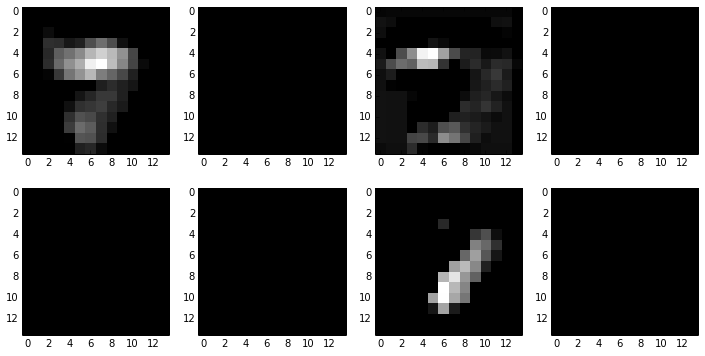

In [12]:
fig = plt.figure()
for i in xrange(8):
    a = fig.add_subplot(4,4,i+1)
    fig.tight_layout()
    plt.imshow(out1[0,:,:,i])

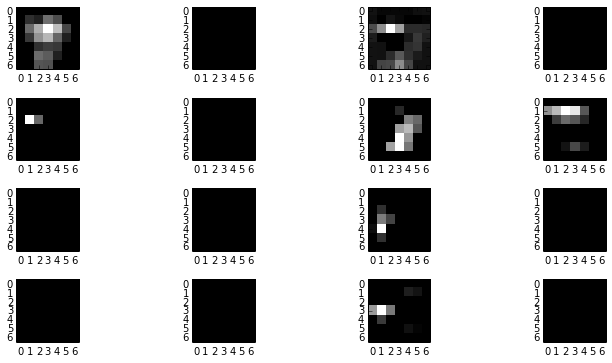

In [13]:
fig = plt.figure()
for i in xrange(16):
    a = fig.add_subplot(8,4,i+1)
    fig.tight_layout()
    plt.imshow(out2[0,:,:,i])